## The first few cells of this tutorial are pre-processing steps in order to get everything working on google colab.

### Part 1 - Install parcels and data download

In [ ]:
!mkdir data_download
!mkdir data
!mkdir PlasticParcels
!mkdir output_data

In [ ]:
## Install parcels
import gdown
import zipfile
import os

In [ ]:
"""
packages = ['cgen',
            'jupyter',
            'matplotlib-base>=2.0.2',
            'netcdf4>=1.1.9',
            'numpy>=1.9.1',
            'platformdirs',
            'psutil',
            'py>=1.4.27',
            'pymbolic',
            'scipy',
            'tqdm',
            'trajan',
            'xarray>=0.10.8',
            'cftime>=1.3.1',
            'dask>=2.0',
            'nbval',
            'scikit-learn',
            'pykdtree',
            'zarr>=2.11.0',
            'black',
            'isort',
            'pytest',
            'pytest-html',
            'coverage',
            'flake8>=2.1.0',
            'pre_commit',
            'pydocsty;e',
            'ipython',
            'numpydoc',
            'nbsphinx',
            'sphinx<6',
            'pandoc>1.12.1,<3',
            'pydata-sphinx-theme',
            'sphinx-autobuild',
            'myst-parser',
            'parcels']
"""
packages = ['cgen',
            'netcdf4>=1.1.9',
            'numpy>=1.9.1',
            'psutil',
            'pymbolic',
            'scipy',
            'tqdm',
            'xarray>=0.10.8',
            'cftime>=1.3.1',
            'dask>=2.0',
            'zarr>=2.11.0',
            'matplotlib-base >=2.0.2',
            'cartopy',
            'parcels']

for package in packages:
  os.system('pip install "'+package+'"')
  print(package)

cgen
jupyter
matplotlib-base>=2.0.2
netcdf4>=1.1.9
numpy>=1.9.1
platformdirs
psutil
py>=1.4.27
pymbolic
scipy
tqdm
trajan
xarray>=0.10.8
cftime>=1.3.1
dask>=2.0
nbval
scikit-learn
pykdtree
zarr>=2.11.0
black
isort
pytest
pytest-html
coverage
flake8>=2.1.0
pre_commit
pydocsty;e
ipython
numpydoc
nbsphinx
sphinx<6
pandoc>1.12.1,<3
pydata-sphinx-theme
sphinx-autobuild
myst-parser
parcels


In [ ]:
## Download required data for the tutorial


# The data are stored on a google-drive account:
# coordinates.zip     https://drive.google.com/file/d/1DMtK76aCZxUOHdJFv1mI_EPTTHz_HIIN/view?usp=sharing
# release.zip         https://drive.google.com/file/d/1v_YofG2b1CMw2e6BaWuJtHghSYCUXBD-/view?usp=sharing
# daily_U.zip         https://drive.google.com/file/d/12QvmLvTC2mnjexpvT6gRug9rFANiJ3_C/view?usp=sharing
# daily_V.zip         https://drive.google.com/file/d/1YZL3B8GPqY-Q3j4LR3Hqx8dRMxntogrp/view?usp=sharing
# daily_W.zip         https://drive.google.com/file/d/1SAUOWJW7z18ee-_DOj6CKj83ysgExU49/view?usp=sharing
# ERA5.zip            https://drive.google.com/file/d/176_-WitbstrclB59ny6RyesBTO78VU3v/view?usp=sharing
# unbeaching.zip      https://drive.google.com/file/d/1WyqL_KqiVtyTkzqZz8cVv2VrdxkPLmdC/view?usp=sharing
# PlasticParcels.zip  https://drive.google.com/file/d/1q45X2x0ngUGduWVN-YDtgNnyD3ijwNqv/view?usp=sharing


file_ids = ['1DMtK76aCZxUOHdJFv1mI_EPTTHz_HIIN',
            '1v_YofG2b1CMw2e6BaWuJtHghSYCUXBD-',
            '12QvmLvTC2mnjexpvT6gRug9rFANiJ3_C',
            '1YZL3B8GPqY-Q3j4LR3Hqx8dRMxntogrp',
            '1SAUOWJW7z18ee-_DOj6CKj83ysgExU49',
            '176_-WitbstrclB59ny6RyesBTO78VU3v',
            '1WyqL_KqiVtyTkzqZz8cVv2VrdxkPLmdC',
            '1q45X2x0ngUGduWVN-YDtgNnyD3ijwNqv']
for file_id in file_ids:
  url = f'https://drive.google.com/uc?id={file_id}'
  output = './data_download/'
  #try:
  #  gdown.download(url, output, quiet=False)
  #except:
  #  print(os.system('wget https://drive.google.com/uc?id='+file_id+' -P '+output))
  gdown.download(url, output, quiet=False)

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1DMtK76aCZxUOHdJFv1mI_EPTTHz_HIIN

but Gdown can't. Please check connections and permissions.

In [ ]:
## Unzip data and delete the .zip file
download_files = os.listdir('./data_download/')
for file in download_files:
  with zipfile.ZipFile('./data_download/'+file, 'r') as zip_ref:
    if file == 'PlasticParcels.zip':
      zip_ref.extractall('./')
    else:
      zip_ref.extractall('./data/')

    os.remove('./data_download/'+file)
    print(file, 'unzipped')
    zip_ref.close()


daily_V.zip unzipped
daily_W.zip unzipped
PlasticParcels.zip unzipped
ERA5.zip unzipped
coordinates.zip unzipped
unbeaching.zip unzipped
release.zip unzipped
daily_U.zip unzipped


## Now the tutorial begins!

In [ ]:
## Library imports
import os
from PlasticParcels.utils import select_files, create_directory, getclosest_ij
from PlasticParcels.helper import create_fieldset, create_particleset, create_kernel, load_default_settings, load_test_settings
from parcels import ParticleFile
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np

In [ ]:
## Model settings
model_settings, particle_settings = load_default_settings()

In [ ]:
fieldset = create_fieldset(model_settings, particle_settings)

In [ ]:
fieldset.computeTimeChunk(0,1)

21600

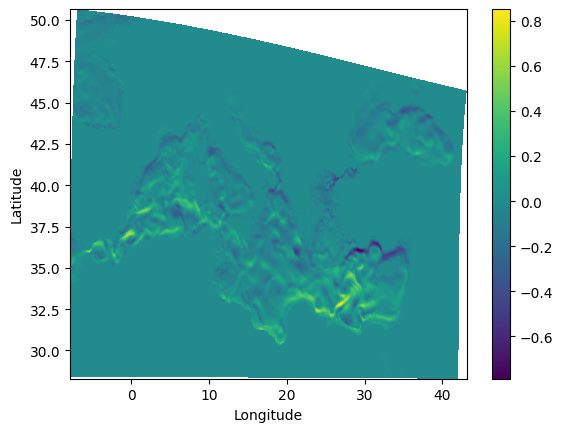

In [ ]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,0])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()
plt.show()

In [ ]:
import pandas as pd
from parcels import Variable, JITParticle, ParticleSet

##TODO: Move this helper function to the helper.py file
def create_particleset_from_file(fieldset, particle_settings):
    """ Helper function to create a Parcels.ParicleSet

    Parameters
    ----------
    model_settings :
        A dictionary of model settings used to create the fieldset
    particle_settings :
        A dictionary of particle settings used to define some ....

    Returns
    -------
    fieldset
        A parcels.FieldSet object
    """

    # Load release type information
    release_type = particle_settings['release_type']
    if release_type == 'coastal':
        release_file = './data/coastal_population_MPW_NEMO0083.csv'
        release_quantity_name = 'MPW_Cell'
    elif release_type == 'rivers':
        release_file = './data/river_emissions_NEMO0083.csv'
        release_quantity_name = 'Emissions'
    elif release_type == 'fisheries':
        release_file = './data/agg_data_fisheries_info.csv'
        release_quantity_name = 'fishing_hours'

    particle_locations = pd.read_csv(release_file)


    # Select specific continent/region/subregion/country/economic status if applicable:
    if 'continent' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Continent'] == particle_settings['continent']]
    if 'region' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Region'] == particle_settings['region']]
    if 'subregion' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Subregion'] == particle_settings['subregion']]
    if 'country' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Country'] == particle_settings['country']]
    if 'economicstatus' in particle_settings.keys():
        particle_locations = particle_locations[particle_locations['Economic status'] == particle_settings['economicstatus']]

    particle_locations = particle_locations.groupby(['Longitude', 'Latitude'])[release_quantity_name].agg('sum').reset_index()
    particle_locations = particle_locations[particle_locations[release_quantity_name]>0]

    depths = None
    times = None
    if 'depths' in particle_settings.keys():
        depths = particle_settings['depths']
    if type(depths) == float:
        depths = np.full(len(particle_locations), depths)

    if 'times' in particle_settings.keys():
        times = particle_settings['times']
    if type(times) == float:
        times = np.full(len(particle_locations), times)


    ## Set particle densities
    if type(particle_settings['particle_density']) == float:
        particle_densities = np.full(len(particle_locations), particle_settings['particle_density'])
    else:
        particle_densities = particle_settings['particle_density']

    ## Set particle lengths
    if type(particle_settings['particle_diameter']) == float:
        particle_diameters = np.full(len(particle_locations), particle_settings['particle_diameter'])
    else:
        particle_diameters = particle_settings['particle_diameter']


    ## Set wind coefficients of particles
    if 'windage_coefficient' in particle_settings.keys():
        if type(particle_settings['windage_coefficient']) == float:
            windage_coefficients = np.full(len(particle_locations), particle_settings['windage_coefficient'])
        else:
            windage_coefficients = particle_settings['windage_coefficient'] # Assumed to be an array of coefficients


    ## Add variables to particle based on fieldset flags
    to_write_tracer = False
    to_write_dynamic = False
    to_write_all = False
    if 'write_output_option' not in particle_settings.keys():
        pass
    elif particle_settings['write_output_option'] == 'none':
        pass
    elif particle_settings['write_output_option'] == 'tracer':
        to_write_tracer = True
    elif particle_settings['write_output_option'] == 'dynamic':
        to_write_tracer = True
        to_write_dynamic = True
    elif particle_settings['write_output_option'] == 'all':
        to_write_tracer = True
        to_write_dynamic = True
        to_write_all = True

    ## Add variables to particle based on fieldset flags
    variables = []
    variables.append(Variable('particle_diameter', dtype=np.float32, to_write=to_write_all))                   # Particle Diameter (assuming spherical particle) [meters] (l_pl)
    variables.append(Variable('particle_density', dtype=np.float32, to_write=to_write_all))                            # Particle Density [kg/m^3] (rho_pl)
    variables.append(Variable('settling_velocity', dtype=np.float64, initial=0., to_write=to_write_dynamic))              # Particle Sinking Velocity [m/s] (v_s)
    variables.append(Variable('seawater_density', dtype=np.float32, to_write=to_write_dynamic))
    variables.append(Variable('absolute_salinity', dtype=np.float64, to_write=to_write_dynamic))
    variables.append(Variable('windage_coefficient', dtype=np.float32, initial=0., to_write=to_write_all))
    variables.append(Variable('algae_amount', dtype=np.float64, initial=0., to_write=to_write_dynamic))

    # Create PlasticParticle class
    PlasticParticle = JITParticle
    for variable in variables:
        setattr(PlasticParticle, variable.name, variable)

    # Add kernel specific variables
    # TODO
    #if fieldset.biofouling_f:
    #if fieldset.wind_f:



    ## Create the particle set
    if not fieldset.wind_f:
        pset = ParticleSet.from_list(fieldset,
                                    PlasticParticle,
                                    lon=particle_locations['Longitude'],
                                    lat=particle_locations['Latitude'],
                                    time=times,
                                    depth=depths,
                                    particle_diameter=particle_diameters,
                                    particle_density=particle_densities
                                    )
    else:
        pset = ParticleSet.from_list(fieldset,
                                    PlasticParticle,
                                    lon=particle_locations['Longitude'],
                                    lat=particle_locations['Latitude'],
                                    time=times,
                                    depth=depths,
                                    particle_diameter=particle_diameters,
                                    particle_density=particle_densities,
                                    windage_coefficient=windage_coefficients
                                    )
    return pset


In [ ]:
## Set particle release locations
## Note, if you set a country, and later want to set for example a continent
##    you have to delete the country entry from the dictionary

release_type = 'coastal' # {'coastal', 'rivers', 'fisheries'}
continent = 'Europe'
#country='Italy'
windage_coefficient = 0.01
particle_diameter = 0.001
particle_density = 1032.
particle_settings.update({'release_type': release_type, # The type of particle releases
                          #country': country,
                          'continent': continent,
                          'windage_coefficient': windage_coefficient, # A float or Nx1 array of windage coefficients, values in [0,1] [percent of wind speed]
                          'particle_density': particle_density, # A float or Nx1 array of particle densities [kg m-3]
                          'particle_diameter': particle_diameter, # A float or Nx1 array of particle lengths [m]
                          'write_output_option': 'all' # Option to write variables. Options: 'none' (default), 'tracer' (saves tracer fields), 'dynamic' (saves all variables that change spatiotemporally), 'all' (saves all variables)
                           })

pset = create_particleset_from_file(fieldset, particle_settings)

In [ ]:
particle_settings

{'start_date': datetime.datetime(2019, 1, 1, 0, 0),
 'runtime': datetime.timedelta(days=360),
 'dt_write': datetime.timedelta(days=1),
 'dt_timestep': datetime.timedelta(seconds=1200),
 'release_type': 'coastal',
 'continent': 'Europe',
 'windage_coefficient': 0.01,
 'particle_density': 1032.0,
 'particle_diameter': 0.001,
 'write_output_option': 'all'}

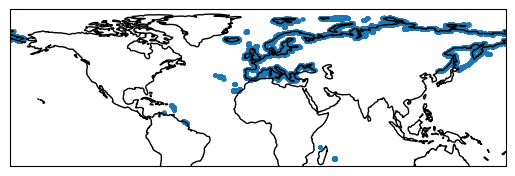

In [ ]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree(), s=5)
ax.coastlines()
plt.show()

In [ ]:
kernels = create_kernel(fieldset, pset)
kernels = [kernels[0], kernels[-1]]# Advection only and OOB delete

In [ ]:
kernels

[<function parcels.application_kernels.advection.AdvectionRK4(particle, fieldset, time)>,
 <function PlasticParcels.kernels.deleteParticle(particle, fieldset, time)>]

In [ ]:
kernel_name = '|'.join([kernel.__name__ for kernel in kernels])
pfile = ParticleFile('./output_data/'+kernel_name+'.zarr', pset, outputdt=particle_settings['dt_write'])

In [ ]:
pset.execute(kernels, runtime=timedelta(days=180), dt=timedelta(minutes=20), output_file=pfile)

INFO: Output files are stored in ./output_data/AdvectionRK4|deleteParticle.zarr.


INFO:parcels.tools.loggers:Output files are stored in ./output_data/AdvectionRK4|deleteParticle.zarr.


100%|██████████| 15552000.0/15552000.0 [03:47<00:00, 68445.55it/s] 


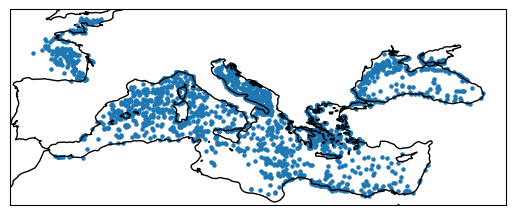

In [ ]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree(), s=5)
ax.coastlines()
plt.show()

In [ ]:
## Using all kernels

In [ ]:
pset = create_particleset_from_file(fieldset, particle_settings)
kernels = create_kernel(fieldset, pset)
kernel_name = '|'.join([kernel.__name__ for kernel in kernels])
pfile = ParticleFile('./output_data/'+kernel_name+'.zarr', pset, outputdt=particle_settings['dt_write'])

In [ ]:
kernels

[<function parcels.application_kernels.advection.AdvectionRK4(particle, fieldset, time)>,
 <function PlasticParcels.kernels.Stokes_drift(particle, fieldset, time)>,
 <function PlasticParcels.kernels.windage_drift(particle, fieldset, time)>,
 <function PlasticParcels.kernels.unbeaching(particle, fieldset, time)>,
 <function PlasticParcels.kernels.periodicBC(particle, fieldset, time)>,
 <function PlasticParcels.kernels.deleteParticle(particle, fieldset, time)>]

In [ ]:
pset.execute(kernels, runtime=timedelta(days=180), dt=timedelta(minutes=20), output_file=pfile)

INFO: Output files are stored in ./output_data/AdvectionRK4|Stokes_drift|windage_drift|unbeaching|periodicBC|deleteParticle.zarr.


INFO:parcels.tools.loggers:Output files are stored in ./output_data/AdvectionRK4|Stokes_drift|windage_drift|unbeaching|periodicBC|deleteParticle.zarr.


100%|██████████| 15552000.0/15552000.0 [10:59<00:00, 23586.27it/s]


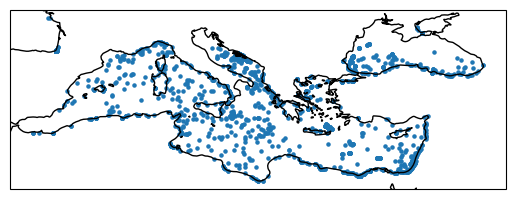

In [ ]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(pset.lon, pset.lat, transform=ccrs.PlateCarree(), s=5)
ax.coastlines()
plt.show()